# MNIST Unlearning

## Import necessary libraries

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score


2024-12-01 23:11:03.934613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733112663.945929 3758213 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733112663.949368 3758213 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 23:11:03.961662: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Load and Preprocess the MNIST Dataset

In [3]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

In [4]:
# Preprocess the data
train_images = train_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.0
test_images  = test_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.0

In [5]:
# Shuffle the training data
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

In [6]:
# Create a validation set from training data
validation_split = 0.1
num_validation_samples = int(validation_split * len(train_images))
validation_images = train_images[:num_validation_samples]
validation_labels = train_labels[:num_validation_samples]
train_images = train_images[num_validation_samples:]
train_labels = train_labels[num_validation_samples:]

## 2. Partition the Data into Shards and Slices

In [15]:
# Define the number of shards and slices
num_shards = 1
num_slices = 1  # Adjusted for larger slice size

In [16]:
# Partition the data into shards
total_train_samples = train_images.shape[0]
shard_size = total_train_samples // num_shards
shards = []

In [17]:
for i in range(num_shards):
    start_index = i * shard_size
    end_index = (i + 1) * shard_size if i != num_shards - 1 else total_train_samples
    shard_images = train_images[start_index:end_index]
    shard_labels = train_labels[start_index:end_index]
    shards.append((shard_images, shard_labels))

In [18]:
print(f'Size of Training Dataset: {train_images.shape[0]}')
print(f'Number of Shards: {num_shards}')
print(f'Size of Each Shard: {len(shards[0][1])}')

Size of Training Dataset: 54000
Number of Shards: 1
Size of Each Shard: 54000


In [19]:
# Function to partition a shard into slices
def partition_into_slices(images, labels, num_slices):
    slice_size = len(images) // num_slices
    slices = []
    for i in range(num_slices):
        start_idx = i * slice_size
        end_idx = (i + 1) * slice_size if i != num_slices - 1 else len(images)
        slice_images = images[start_idx:end_idx]
        slice_labels = labels[start_idx:end_idx]
        slices.append((slice_images, slice_labels))
    return slices

In [20]:
shard_images, shard_labels = shards[0]
print(f'Number of Samples Per Slice: {len(partition_into_slices(shard_images, shard_labels, num_slices)[0][1])}')

Number of Samples Per Slice: 54000


## 3. Initialize Models for Each Shard

In [21]:
# Function to create the model
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28,28,1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## 4. Incremental Training over Slices

In [22]:
# Lists to store models and history
shard_models = []
histories = []

In [23]:
# Training parameters
epochs_per_slice = 5  # Increased epochs per slice
batch_size = 32       # Reduced batch size

In [24]:
for shard_idx, (shard_images, shard_labels) in enumerate(shards):
    print(f"\nInitializing model for Shard {shard_idx+1}/{num_shards}")
    model = create_model()

    # Partition the shard into slices
    slices = partition_into_slices(shard_images, shard_labels, num_slices)

    # Train incrementally over slices
    for slice_idx, (slice_images, slice_labels) in enumerate(slices):
        print(f"Training on Slice {slice_idx+1}/{num_slices} of Shard {shard_idx+1}")
        history = model.fit(
            slice_images, slice_labels,
            epochs=epochs_per_slice,
            batch_size=batch_size,
            verbose=1,
            validation_data=(validation_images, validation_labels)
        )
        # Optionally, store histories for each slice
        histories.append(history)

    shard_models.append(model)


Initializing model for Shard 1/1


I0000 00:00:1733112687.871828 3758213 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37130 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB MIG 3g.40gb, pci bus id: 0000:81:00.0, compute capability: 8.0


Training on Slice 1/1 of Shard 1
Epoch 1/5


I0000 00:00:1733112690.709258 3761569 service.cc:148] XLA service 0x7f7710016540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733112690.709295 3761569 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB MIG 3g.40gb, Compute Capability 8.0
2024-12-01 23:11:30.755841: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733112690.996165 3761569 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-01 23:11:31.221228: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  73/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5915 - loss: 1.3875

I0000 00:00:1733112693.769037 3761569 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9076 - loss: 0.3068 - val_accuracy: 0.9857 - val_loss: 0.0467
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9779 - loss: 0.0704 - val_accuracy: 0.9898 - val_loss: 0.0337
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9837 - loss: 0.0521 - val_accuracy: 0.9898 - val_loss: 0.0313
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9865 - loss: 0.0454 - val_accuracy: 0.9888 - val_loss: 0.0356
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9877 - loss: 0.0409 - val_accuracy: 0.9910 - val_loss: 0.0315


## 5. Aggregate the Models

In [25]:
# Function to make predictions using the ensemble of models
def ensemble_predictions(models, data):
    predictions = np.array([model.predict(data) for model in models])
    avg_predictions = np.mean(predictions, axis=0)
    return np.argmax(avg_predictions, axis=1)

## 6. Evaluate the Aggregated Model

In [26]:
# Make predictions on the test set
ensemble_preds = ensemble_predictions(shard_models, test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [27]:
# Calculate accuracy
ensemble_accuracy = accuracy_score(test_labels, ensemble_preds)
print(f"\nEnsemble Model Test Accuracy: {ensemble_accuracy * 100:.2f}%")


Ensemble Model Test Accuracy: 99.05%


## 7. Plot Training and Validation Graphs

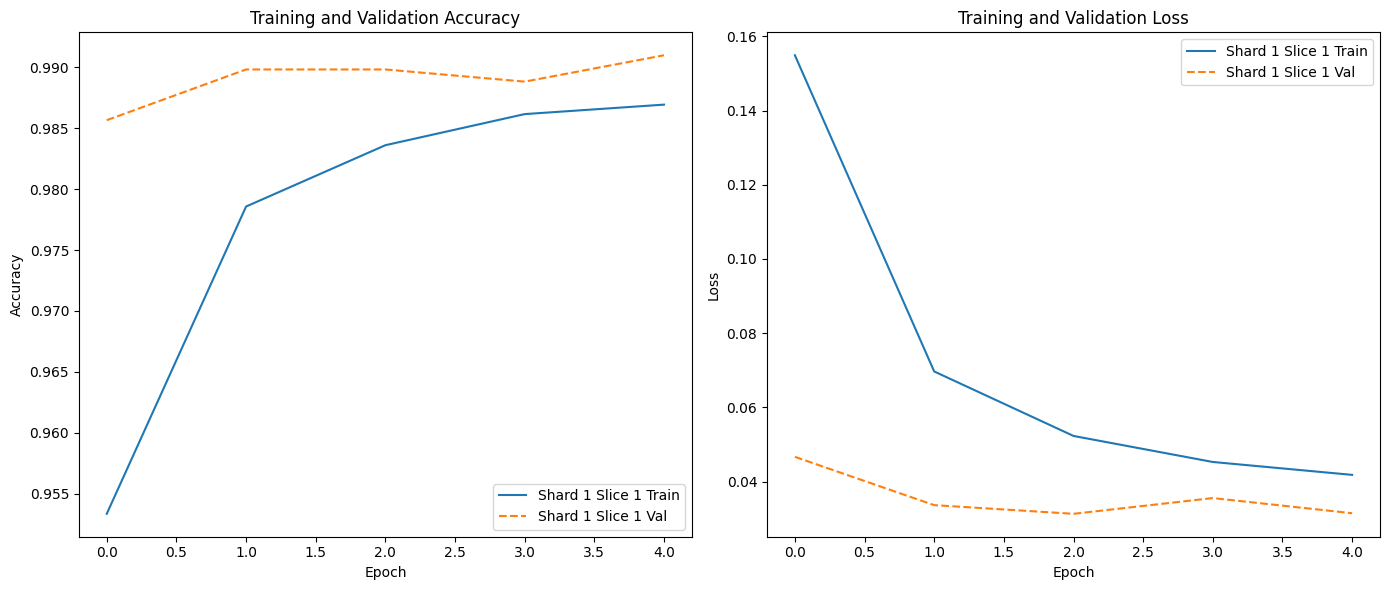

In [28]:
# Plot settings
plt.figure(figsize=(14, 6))

# Initialize subplots for accuracy and loss
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# Plot accuracy and loss for each shard's last slice
for i, history in enumerate(histories):
    # Accuracy
    ax1.plot(history.history['accuracy'], label=f'Shard {i//num_slices+1} Slice {i%num_slices+1} Train')
    ax1.plot(history.history['val_accuracy'], label=f'Shard {i//num_slices+1} Slice {i%num_slices+1} Val', linestyle='--')
    # Loss
    ax2.plot(history.history['loss'], label=f'Shard {i//num_slices+1} Slice {i%num_slices+1} Train')
    ax2.plot(history.history['val_loss'], label=f'Shard {i//num_slices+1} Slice {i%num_slices+1} Val', linestyle='--')
    
# Customize plots
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 8. Removing Specific Data Samples

In [32]:
# Simulate unlearning by removing all samples of label '0' from Shard 3
label_to_remove = 0
unlearn_shard_idx = 0  # Shard indices start from 0

In [33]:
# Get the data for the shard
shard_images, shard_labels = shards[unlearn_shard_idx]

In [34]:
# Partition the shard into slices
slices = partition_into_slices(shard_images, shard_labels, num_slices)

In [35]:
# Identify slices containing the label to remove and remove the data
for i in range(len(slices)):
    slice_images, slice_labels = slices[i]
    mask = slice_labels != label_to_remove
    # Check if any samples remain after removal
    if np.any(mask):
        slices[i] = (slice_images[mask], slice_labels[mask])
    else:
        # If all samples are removed, create an empty array
        slices[i] = (np.array([]).reshape(0,28,28,1), np.array([]))

In [36]:
# Retrain only the affected shard
print(f"\nRetraining Shard {unlearn_shard_idx+1} after unlearning label '{label_to_remove}'")
model = create_model()


Retraining Shard 1 after unlearning label '0'


In [37]:
for slice_idx, (slice_images, slice_labels) in enumerate(slices):
    if len(slice_labels) == 0:
        print(f"Slice {slice_idx+1}/{len(slices)} of Shard {unlearn_shard_idx+1} is empty after unlearning.")
        continue
    print(f"Training on Slice {slice_idx+1}/{len(slices)} of Shard {unlearn_shard_idx+1}")
    model.fit(
        slice_images, slice_labels,
        epochs=epochs_per_slice,
        batch_size=batch_size,
        verbose=1,
        validation_data=(validation_images, validation_labels)
    )

Training on Slice 1/1 of Shard 1
Epoch 1/5
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9019 - loss: 0.3242 - val_accuracy: 0.8847 - val_loss: 0.7162
Epoch 2/5
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9781 - loss: 0.0707 - val_accuracy: 0.8812 - val_loss: 0.8093
Epoch 3/5
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9828 - loss: 0.0562 - val_accuracy: 0.8845 - val_loss: 0.9541
Epoch 4/5
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9856 - loss: 0.0469 - val_accuracy: 0.8808 - val_loss: 0.8778
Epoch 5/5
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9864 - loss: 0.0435 - val_accuracy: 0.8872 - val_loss: 0.8908


In [38]:
# Replace the old model with the retrained model
shard_models[unlearn_shard_idx] = model

In [39]:
# Recompute the ensemble accuracy
ensemble_preds = ensemble_predictions(shard_models, test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [40]:
# Calculate accuracy
ensemble_accuracy = accuracy_score(test_labels, ensemble_preds)
print(f"\nEnsemble Model Test Accuracy after Unlearning: {ensemble_accuracy * 100:.2f}%")


Ensemble Model Test Accuracy after Unlearning: 89.55%


In [30]:
# Check accuracy on the removed class
removed_class_mask = test_labels == label_to_remove
if np.any(removed_class_mask):
    removed_class_accuracy = accuracy_score(
        test_labels[removed_class_mask],
        ensemble_preds[removed_class_mask]
    )
    print(f"Accuracy on removed class '{label_to_remove}': {removed_class_accuracy * 100:.2f}%")
else:
    print(f"No test samples of label '{label_to_remove}' to evaluate.")

Accuracy on removed class '0': 98.67%
